## PSO-CNN:
In this Notebook we will deploy the Particle Swarm Optimizer to find the best hyperparameters of a fully connect Convolution Neural Network. 

### Install the pyswarm package
pyswarm is a Python implementation of the Particle Swarm Optimization (PSO) algorithm, which is used for optimization problems. PSO is inspired by the social behavior of birds flocking or fish schooling and is commonly used to optimize functions in various fields, including machine learning, engineering, and economics.

In [1]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=c3175ebfe131ad8f224881dc153a20c1987208ff3fcc1f4acb28a6e9fc8d3a14
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


### Import necessary Librairies

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyswarm import pso
import os

2024-05-04 06:08:28.474241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 06:08:28.474384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 06:08:28.622666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting default parameters.

In [5]:
BATCH_SIZE = 20
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

### Load the dataset
Loading our dataset into the `dataset` variable, we have run the notebook on Kaggle and used the loading methods according to Kaggle's standards. We have set the image size as 128 and a batch size of 20. our dataset conatins 3829 images belonging to 6 classes.

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/rdidataset/Rice_Leaf_AUG/",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3829 files belonging to 6 classes.


### Data Partitions
This Python function, `get_dataset_partitions_tf`, partitions a given dataset (`ds`) into training, validation, and test sets using TensorFlow's `tf.data.Dataset` API. It takes arguments for the splits (`train_split`, `val_split`, `test_split`), shuffling options (`shuffle`, `shuffle_size`), and asserts that the splits sum to 1. It shuffles the dataset if specified, then calculates and returns the three dataset partitions.

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Checking our classes.

In [9]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Sheath Blight']

### Visualizing our dataset

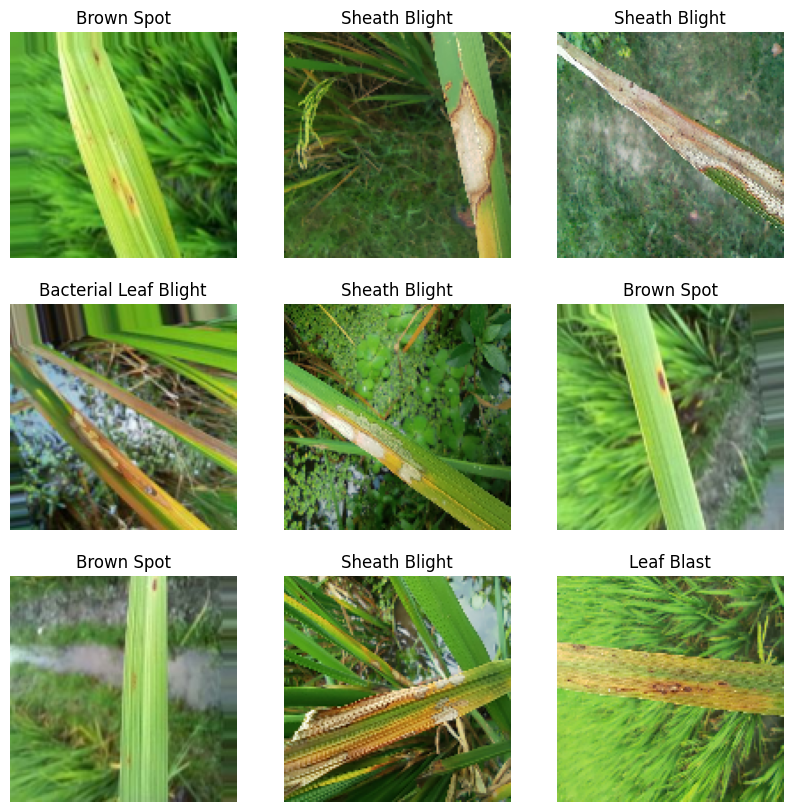

In [10]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### PSO-CNN
This code uses the `pyswarm` package to perform Particle Swarm Optimization (PSO) to find the best hyperparameters for a convolutional neural network (CNN) model. Here's a breakdown:

### `train_network` function:
- This function defines a CNN model with three convolutional layers followed by max pooling and two dense layers.
- It compiles the model using the Adam optimizer, sparse categorical crossentropy loss function, and accuracy metric.
- The model is trained on the training dataset (`train_ds`) with validation on the validation dataset (`val_ds`) for 10 epochs.
- Finally, the model is evaluated on the test dataset (`test_ds`), and the negative accuracy is returned.

### `lb` and `ub` lists:
- These lists define the lower bounds (`lb`) and upper bounds (`ub`) for the hyperparameters `neuron_1`, `neuron_2`, and `neuron_3`.

### PSO Optimization:
- The PSO algorithm is used to find the best hyperparameters for the `train_network` function.
- The `swarmsize` parameter defines the size of the swarm, and `maxiter` specifies the maximum number of iterations.
- The `pso` function returns the best hyperparameters (`best_hyperparams`) and their corresponding negative accuracy.


In [11]:
def train_network(hyperparameters):
    neuron_1, neuron_2, neuron_3 = int(hyperparameters[0]), int(hyperparameters[1]), int(hyperparameters[2])

    psomodel = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(neuron_1, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(neuron_2, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(neuron_3, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
    )
    psomodel.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

    psomodel.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
    )
    _ , scores = psomodel.evaluate(test_ds)
    return -scores

In [15]:
lb = [10,10,10]
ub = [100,100,100]
best_hyperparams, _ = pso(train_network, lb, ub, swarmsize=5, maxiter=5)

Epoch 1/10
 63/153 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.2157 - loss: 1.7577

W0000 00:00:1714808973.624474     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.2785 - loss: 1.6556 - val_accuracy: 0.6152 - val_loss: 1.1542
Epoch 2/10


W0000 00:00:1714808988.183121     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.5512 - loss: 1.1884 - val_accuracy: 0.6711 - val_loss: 0.8520
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.6351 - loss: 0.9758 - val_accuracy: 0.7053 - val_loss: 0.7719
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.7086 - loss: 0.8096 - val_accuracy: 0.7737 - val_loss: 0.6819
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7675 - loss: 0.6308 - val_accuracy: 0.8421 - val_loss: 0.4381
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8264 - loss: 0.4801 - val_accuracy: 0.8605 - val_loss: 0.4221
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8767 - loss: 0.3609 - val_accuracy: 0.9079 - val_loss: 0.2990
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9026 - loss: 0.2616 - val_accuracy: 0.9553 - val_loss: 0.1877
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9447 - loss: 0.1807 - val_accurac

W0000 00:00:1714809271.182881     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.2168 - loss: 1.8011 - val_accuracy: 0.4105 - val_loss: 1.3983
Epoch 2/10


W0000 00:00:1714809286.319843     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/153 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.5032 - loss: 1.2531

W0000 00:00:1714809302.769321     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.4886 - loss: 1.2902 - val_accuracy: 0.6000 - val_loss: 1.0226
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.5535 - loss: 1.1318 - val_accuracy: 0.7105 - val_loss: 0.8571
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.6565 - loss: 0.9178 - val_accuracy: 0.7289 - val_loss: 0.8078
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.7062 - loss: 0.7887 - val_accuracy: 0.7500 - val_loss: 0.6568
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7206 - loss: 0.7203 - val_accuracy: 0.8184 - val_loss: 0.5565
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.8000 - loss: 0.5562 - val_accuracy: 0.8763 - val_loss: 0.3915
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8451 - loss: 0.4417 - val_accuracy: 0.8895 - val_loss: 0.3516
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.8848 - loss: 0.3511 - val_ac

W0000 00:00:1714809581.563984     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.2720 - loss: 1.7096 - val_accuracy: 0.4184 - val_loss: 1.3424
Epoch 2/10


W0000 00:00:1714809599.340156     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.4783 - loss: 1.2912 - val_accuracy: 0.5799 - val_loss: 1.0948
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.6068 - loss: 1.0363 - val_accuracy: 0.6342 - val_loss: 0.9711
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.6316 - loss: 0.9747 - val_accuracy: 0.6684 - val_loss: 0.8675
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.7135 - loss: 0.7828 - val_accuracy: 0.7395 - val_loss: 0.7073
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.7727 - loss: 0.6300 - val_accuracy: 0.7711 - val_loss: 0.5702
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.8184 - loss: 0.4834 - val_accuracy: 0.8526 - val_loss: 0.3922
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.8855 - loss: 0.3497 - val_accuracy: 0.9474 - val_loss: 0.1716
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.9471 - loss: 0.1884 - val_accurac

W0000 00:00:1714809896.181493     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.1534 - loss: 1.7939 - val_accuracy: 0.1737 - val_loss: 1.7911
Epoch 2/10


W0000 00:00:1714809911.856929     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.1802 - loss: 1.7918 - val_accuracy: 0.1632 - val_loss: 1.7922
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - accuracy: 0.1716 - loss: 1.7919 - val_accuracy: 0.1816 - val_loss: 1.7913
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.1768 - loss: 1.7918 - val_accuracy: 0.1632 - val_loss: 1.7918
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.1800 - loss: 1.7915 - val_accuracy: 0.1421 - val_loss: 1.7929
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1593 - loss: 1.7922 - val_accuracy: 0.1526 - val_loss: 1.7920
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1738 - loss: 1.7916 - val_accuracy: 0.1553 - val_loss: 1.7916
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1701 - loss: 1.7918 - val_accuracy: 0.1474 - val_loss: 1.7926
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1753 - loss: 1.7917 - val_accu

W0000 00:00:1714810502.993186     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.2740 - loss: 1.6764 - val_accuracy: 0.5237 - val_loss: 1.2112
Epoch 2/10


W0000 00:00:1714810521.552044     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5209 - loss: 1.2319 - val_accuracy: 0.6605 - val_loss: 0.8964
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6225 - loss: 1.0157 - val_accuracy: 0.6421 - val_loss: 0.8868
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6961 - loss: 0.8195 - val_accuracy: 0.7553 - val_loss: 0.6960
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7476 - loss: 0.6965 - val_accuracy: 0.7868 - val_loss: 0.6374
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.8119 - loss: 0.5427 - val_accuracy: 0.8579 - val_loss: 0.4275
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8598 - loss: 0.4117 - val_accuracy: 0.8763 - val_loss: 0.3797
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8926 - loss: 0.3294 - val_accuracy: 0.9263 - val_loss: 0.2614
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.9243 - loss: 0.2203 - val_accurac

W0000 00:00:1714810806.303983     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/153 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2426 - loss: 1.7120

W0000 00:00:1714810809.580953     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - accuracy: 0.2757 - loss: 1.6662 - val_accuracy: 0.5184 - val_loss: 1.2566
Epoch 2/10


W0000 00:00:1714810823.578844     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.5487 - loss: 1.1724 - val_accuracy: 0.7127 - val_loss: 0.8370
Epoch 3/10


W0000 00:00:1714810852.200422     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.6537 - loss: 0.9427 - val_accuracy: 0.6947 - val_loss: 0.8438
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.7104 - loss: 0.7886 - val_accuracy: 0.7079 - val_loss: 0.7667
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7665 - loss: 0.6370 - val_accuracy: 0.8237 - val_loss: 0.5272
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8380 - loss: 0.4791 - val_accuracy: 0.8632 - val_loss: 0.3933
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8558 - loss: 0.3940 - val_accuracy: 0.9000 - val_loss: 0.3160
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8993 - loss: 0.2796 - val_accuracy: 0.9474 - val_loss: 0.2234
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.9313 - loss: 0.2054 - val_accuracy: 0.9711 - val_loss: 0.1094
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9548 - loss: 0.1473 - val_accu

W0000 00:00:1714811111.486709     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.2787 - loss: 1.6759 - val_accuracy: 0.5368 - val_loss: 1.2159
Epoch 2/10


W0000 00:00:1714811129.539467     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5361 - loss: 1.2158 - val_accuracy: 0.6605 - val_loss: 0.9845
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6244 - loss: 0.9646 - val_accuracy: 0.7000 - val_loss: 0.8590
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7141 - loss: 0.7734 - val_accuracy: 0.7632 - val_loss: 0.6943
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7596 - loss: 0.6502 - val_accuracy: 0.8158 - val_loss: 0.4830
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8167 - loss: 0.5086 - val_accuracy: 0.8737 - val_loss: 0.4051
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8684 - loss: 0.3923 - val_accuracy: 0.8921 - val_loss: 0.3001
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9143 - loss: 0.2577 - val_accuracy: 0.9263 - val_loss: 0.2202
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9193 - loss: 0.2436 - val_accurac

W0000 00:00:1714811417.316938     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.1852 - loss: 1.7989 - val_accuracy: 0.1789 - val_loss: 1.7916
Epoch 2/10


W0000 00:00:1714811436.456153     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.2239 - loss: 1.7562 - val_accuracy: 0.4605 - val_loss: 1.3798
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.4572 - loss: 1.3367 - val_accuracy: 0.5632 - val_loss: 1.1431
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.5480 - loss: 1.1418 - val_accuracy: 0.6369 - val_loss: 0.9880
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6186 - loss: 0.9874 - val_accuracy: 0.6921 - val_loss: 0.8222
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7187 - loss: 0.7700 - val_accuracy: 0.8289 - val_loss: 0.5511
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7911 - loss: 0.5832 - val_accuracy: 0.8184 - val_loss: 0.5569
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.8308 - loss: 0.4762 - val_accuracy: 0.9132 - val_loss: 0.2926
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.9058 - loss: 0.3005 - val_accu

W0000 00:00:1714811725.240221     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/153 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2313 - loss: 1.7549

W0000 00:00:1714811728.579114     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - accuracy: 0.2931 - loss: 1.6546 - val_accuracy: 0.5395 - val_loss: 1.2325
Epoch 2/10


W0000 00:00:1714811742.675126     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.5458 - loss: 1.1760 - val_accuracy: 0.6921 - val_loss: 0.8796
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.6629 - loss: 0.9250 - val_accuracy: 0.7421 - val_loss: 0.7606
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.7134 - loss: 0.7729 - val_accuracy: 0.7684 - val_loss: 0.5837
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.7751 - loss: 0.6487 - val_accuracy: 0.8184 - val_loss: 0.5177
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.8385 - loss: 0.4612 - val_accuracy: 0.8947 - val_loss: 0.3443
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.8801 - loss: 0.3727 - val_accuracy: 0.8211 - val_loss: 0.4341
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 91ms/step - accuracy: 0.9015 - loss: 0.2897 - val_accuracy: 0.9500 - val_loss: 0.1686
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9361 - loss: 0.1901 - val_accurac

W0000 00:00:1714812020.280551     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 50/153 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.2213 - loss: 1.8018

W0000 00:00:1714812023.489957     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 120ms/step - accuracy: 0.2625 - loss: 1.7159 - val_accuracy: 0.4789 - val_loss: 1.3578
Epoch 2/10


W0000 00:00:1714812038.399516     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.4759 - loss: 1.3139 - val_accuracy: 0.5395 - val_loss: 1.1578
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.5562 - loss: 1.1245 - val_accuracy: 0.6184 - val_loss: 0.9536
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6320 - loss: 0.9481 - val_accuracy: 0.7615 - val_loss: 0.6840
Epoch 5/10


W0000 00:00:1714812121.856680     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.7141 - loss: 0.7551 - val_accuracy: 0.7816 - val_loss: 0.6323
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.7680 - loss: 0.6341 - val_accuracy: 0.8211 - val_loss: 0.5621
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.8372 - loss: 0.4633 - val_accuracy: 0.8895 - val_loss: 0.3397
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - accuracy: 0.8687 - loss: 0.3750 - val_accuracy: 0.9184 - val_loss: 0.2527
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.8988 - loss: 0.2831 - val_accuracy: 0.9026 - val_loss: 0.2620
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9291 - loss: 0.2158 - val_accuracy: 0.9395 - val_loss: 0.1605
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9507 - loss: 0.2015
Epoch 1/10
  1/153 ━━━━━━━━━━━━━━━━━━━━ 44:51 18s/step - accuracy: 0.0000e+00 - loss: 1.8257

W0000 00:00:1714812317.268453     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - accuracy: 0.2860 - loss: 1.6292 - val_accuracy: 0.5316 - val_loss: 1.1933
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5414 - loss: 1.1871 - val_accuracy: 0.6553 - val_loss: 0.9020
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6610 - loss: 0.9176 - val_accuracy: 0.7237 - val_loss: 0.7361
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.7173 - loss: 0.7657 - val_accuracy: 0.8076 - val_loss: 0.6220
Epoch 5/10


W0000 00:00:1714812422.386277     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.7654 - loss: 0.6532 - val_accuracy: 0.8237 - val_loss: 0.5163
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8194 - loss: 0.5249 - val_accuracy: 0.9211 - val_loss: 0.2740
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.8897 - loss: 0.3117 - val_accuracy: 0.9447 - val_loss: 0.2047
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9365 - loss: 0.2076 - val_accuracy: 0.9579 - val_loss: 0.1376
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.9608 - loss: 0.1314 - val_accuracy: 0.9842 - val_loss: 0.0926
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9521 - loss: 0.1426 - val_accuracy: 0.9737 - val_loss: 0.0767
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9681 - loss: 0.0948
Epoch 1/10
 13/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1365 - loss: 1.9142

W0000 00:00:1714812630.751003     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.1680 - loss: 1.8071 - val_accuracy: 0.1658 - val_loss: 1.7919
Epoch 2/10


W0000 00:00:1714812648.762710     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.1771 - loss: 1.7907 - val_accuracy: 0.1474 - val_loss: 1.7936
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1714 - loss: 1.7921 - val_accuracy: 0.1868 - val_loss: 1.7898
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1823 - loss: 1.7868 - val_accuracy: 0.1474 - val_loss: 1.7930
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.1617 - loss: 1.7920 - val_accuracy: 0.1789 - val_loss: 1.7916
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1721 - loss: 1.7916 - val_accuracy: 0.2289 - val_loss: 1.7458
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.3447 - loss: 1.5844 - val_accuracy: 0.5474 - val_loss: 1.1755
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5433 - loss: 1.1560 - val_accuracy: 0.6289 - val_loss: 0.9229
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6369 - loss: 0.9714 - val_accurac

W0000 00:00:1714812935.493474     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/153 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.1646 - loss: 1.7993

W0000 00:00:1714812939.624668     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.2425 - loss: 1.7168 - val_accuracy: 0.5026 - val_loss: 1.2960
Epoch 2/10


W0000 00:00:1714812954.708139     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5290 - loss: 1.2496 - val_accuracy: 0.6684 - val_loss: 1.0005
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6153 - loss: 1.0162 - val_accuracy: 0.6711 - val_loss: 0.9304
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6623 - loss: 0.8938 - val_accuracy: 0.7500 - val_loss: 0.6886
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7195 - loss: 0.7220 - val_accuracy: 0.7526 - val_loss: 0.6469
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.8171 - loss: 0.5228 - val_accuracy: 0.8618 - val_loss: 0.4035
Epoch 7/10


W0000 00:00:1714813095.536340     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.8499 - loss: 0.4269 - val_accuracy: 0.8947 - val_loss: 0.3674
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.8775 - loss: 0.3609 - val_accuracy: 0.9053 - val_loss: 0.3028
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9238 - loss: 0.2335 - val_accuracy: 0.8868 - val_loss: 0.2761
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9340 - loss: 0.1958 - val_accuracy: 0.9579 - val_loss: 0.1272
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9425 - loss: 0.1489
Epoch 1/10
 15/153 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2078 - loss: 1.8184

W0000 00:00:1714813255.361206     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.3136 - loss: 1.6317 - val_accuracy: 0.5263 - val_loss: 1.1934
Epoch 2/10


W0000 00:00:1714813270.040169     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5338 - loss: 1.1975 - val_accuracy: 0.6605 - val_loss: 0.9634
Epoch 3/10
 89/153 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6349 - loss: 0.9215

W0000 00:00:1714813315.349134     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.6338 - loss: 0.9419 - val_accuracy: 0.5474 - val_loss: 1.1527
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.6784 - loss: 0.8478 - val_accuracy: 0.7579 - val_loss: 0.6566
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.7669 - loss: 0.6578 - val_accuracy: 0.8316 - val_loss: 0.4772
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.8453 - loss: 0.4636 - val_accuracy: 0.8868 - val_loss: 0.3892
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.8819 - loss: 0.3606 - val_accuracy: 0.9000 - val_loss: 0.3036
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.8907 - loss: 0.3040 - val_accuracy: 0.9421 - val_loss: 0.2066
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 94ms/step - accuracy: 0.9189 - loss: 0.2461 - val_accuracy: 0.9632 - val_loss: 0.1189
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.9668 - loss: 0.1081 - val_accur

W0000 00:00:1714813554.109863     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/153 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3124 - loss: 1.6470

W0000 00:00:1714813557.731883     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.3262 - loss: 1.6210 - val_accuracy: 0.5158 - val_loss: 1.2408
Epoch 2/10


W0000 00:00:1714813571.899415     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5735 - loss: 1.1351 - val_accuracy: 0.6553 - val_loss: 0.8949
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6451 - loss: 0.9414 - val_accuracy: 0.7000 - val_loss: 0.7441
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7015 - loss: 0.8124 - val_accuracy: 0.7632 - val_loss: 0.6188
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7569 - loss: 0.6679 - val_accuracy: 0.7947 - val_loss: 0.5292
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.8129 - loss: 0.5155 - val_accuracy: 0.8591 - val_loss: 0.4018
Epoch 7/10


W0000 00:00:1714813711.833097     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.8670 - loss: 0.3877 - val_accuracy: 0.9289 - val_loss: 0.2440
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.8917 - loss: 0.3138 - val_accuracy: 0.8789 - val_loss: 0.3296
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.9127 - loss: 0.2674 - val_accuracy: 0.9474 - val_loss: 0.1632
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9397 - loss: 0.1983 - val_accuracy: 0.9632 - val_loss: 0.1262
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9590 - loss: 0.1320
Epoch 1/10
  9/153 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1906 - loss: 1.8354

W0000 00:00:1714813858.225978     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/153 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2595 - loss: 1.7114

W0000 00:00:1714813862.663335     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.2929 - loss: 1.6563 - val_accuracy: 0.5763 - val_loss: 1.1578
Epoch 2/10


W0000 00:00:1714813877.196526     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.5760 - loss: 1.0999 - val_accuracy: 0.6721 - val_loss: 0.9318
Epoch 3/10


W0000 00:00:1714813905.819194     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6492 - loss: 0.9574 - val_accuracy: 0.7316 - val_loss: 0.7068
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7357 - loss: 0.7203 - val_accuracy: 0.8158 - val_loss: 0.4987
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7666 - loss: 0.6230 - val_accuracy: 0.8579 - val_loss: 0.3922
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.8678 - loss: 0.4000 - val_accuracy: 0.9079 - val_loss: 0.2574
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.9071 - loss: 0.2755 - val_accuracy: 0.9026 - val_loss: 0.3235
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.9091 - loss: 0.2631 - val_accuracy: 0.9763 - val_loss: 0.1137
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9552 - loss: 0.1336 - val_accuracy: 0.9658 - val_loss: 0.0977
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.9635 - loss: 0.1141 - val_acc

W0000 00:00:1714814170.509746     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.2514 - loss: 1.7071 - val_accuracy: 0.4316 - val_loss: 1.3586
Epoch 2/10


W0000 00:00:1714814189.336296     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.4564 - loss: 1.3352 - val_accuracy: 0.5342 - val_loss: 1.1547
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5882 - loss: 1.0926 - val_accuracy: 0.7132 - val_loss: 0.8394
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.6555 - loss: 0.9029 - val_accuracy: 0.7263 - val_loss: 0.7315
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7484 - loss: 0.6791 - val_accuracy: 0.8428 - val_loss: 0.4697
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7936 - loss: 0.5942 - val_accuracy: 0.8842 - val_loss: 0.3590
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.8797 - loss: 0.3822 - val_accuracy: 0.9526 - val_loss: 0.2019
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9168 - loss: 0.2584 - val_accuracy: 0.9447 - val_loss: 0.1653
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.9491 - loss: 0.1755 - val_accu

W0000 00:00:1714814479.359258     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/153 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1629 - loss: 1.8024

W0000 00:00:1714814483.051212     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.1614 - loss: 1.7979 - val_accuracy: 0.1526 - val_loss: 1.7926
Epoch 2/10


W0000 00:00:1714814497.901026     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.1731 - loss: 1.7916 - val_accuracy: 0.1658 - val_loss: 1.7922
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.1795 - loss: 1.7917 - val_accuracy: 0.1553 - val_loss: 1.7925
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.1719 - loss: 1.7917 - val_accuracy: 0.1684 - val_loss: 1.7914
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.1773 - loss: 1.7918 - val_accuracy: 0.1789 - val_loss: 1.7914
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.1655 - loss: 1.7916 - val_accuracy: 0.1711 - val_loss: 1.7924
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.1680 - loss: 1.7918 - val_accuracy: 0.1579 - val_loss: 1.7917
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.1593 - loss: 1.7915 - val_accuracy: 0.1605 - val_loss: 1.7924
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.1752 - loss: 1.7920 - val_accura

W0000 00:00:1714814788.964326     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/153 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.2214 - loss: 1.7561

W0000 00:00:1714814792.712597     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.3101 - loss: 1.6076 - val_accuracy: 0.5158 - val_loss: 1.2104
Epoch 2/10


W0000 00:00:1714814807.901069     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.5499 - loss: 1.1595 - val_accuracy: 0.5921 - val_loss: 1.0379
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.6270 - loss: 0.9883 - val_accuracy: 0.6748 - val_loss: 0.8706
Epoch 4/10


W0000 00:00:1714814865.295185     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6958 - loss: 0.8090 - val_accuracy: 0.7895 - val_loss: 0.6165
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7648 - loss: 0.6490 - val_accuracy: 0.7947 - val_loss: 0.5360
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8259 - loss: 0.4968 - val_accuracy: 0.8605 - val_loss: 0.4123
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8610 - loss: 0.3874 - val_accuracy: 0.8842 - val_loss: 0.3429
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8899 - loss: 0.3339 - val_accuracy: 0.9553 - val_loss: 0.1416
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9135 - loss: 0.2607 - val_accuracy: 0.9342 - val_loss: 0.1892
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9294 - loss: 0.1950 - val_accuracy: 0.9868 - val_loss: 0.0901
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9818 - loss: 0.1064
Epoch 1/10
 13/153 ━━━━━━━

W0000 00:00:1714815095.874420     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.3170 - loss: 1.6565 - val_accuracy: 0.5237 - val_loss: 1.2129
Epoch 2/10


W0000 00:00:1714815110.982311     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/153 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5371 - loss: 1.1982

W0000 00:00:1714815127.637824     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.5514 - loss: 1.1619 - val_accuracy: 0.6132 - val_loss: 1.0291
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.6433 - loss: 0.9379 - val_accuracy: 0.6526 - val_loss: 0.8760
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6950 - loss: 0.8149 - val_accuracy: 0.7237 - val_loss: 0.7833
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7616 - loss: 0.6677 - val_accuracy: 0.8105 - val_loss: 0.5229
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.8081 - loss: 0.5406 - val_accuracy: 0.8526 - val_loss: 0.4469
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.8371 - loss: 0.4560 - val_accuracy: 0.8482 - val_loss: 0.4278
Epoch 8/10


W0000 00:00:1714815284.345993     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8866 - loss: 0.3183 - val_accuracy: 0.8711 - val_loss: 0.3979
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9082 - loss: 0.2759 - val_accuracy: 0.9316 - val_loss: 0.2088
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9405 - loss: 0.1749 - val_accuracy: 0.9526 - val_loss: 0.1353
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9322 - loss: 0.1700
Epoch 1/10
 10/153 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2079 - loss: 1.8101

W0000 00:00:1714815403.586513     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/153 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.2362 - loss: 1.7750

W0000 00:00:1714815407.407026     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.2820 - loss: 1.7032 - val_accuracy: 0.4526 - val_loss: 1.3287
Epoch 2/10


W0000 00:00:1714815422.326717     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.5572 - loss: 1.1966 - val_accuracy: 0.6079 - val_loss: 0.9837
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6343 - loss: 0.9392 - val_accuracy: 0.7184 - val_loss: 0.7787
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6990 - loss: 0.7966 - val_accuracy: 0.7947 - val_loss: 0.5957
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7661 - loss: 0.6456 - val_accuracy: 0.7711 - val_loss: 0.6089
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.8201 - loss: 0.5259 - val_accuracy: 0.8184 - val_loss: 0.4627
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8576 - loss: 0.4238 - val_accuracy: 0.9158 - val_loss: 0.2599
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8914 - loss: 0.3162 - val_accuracy: 0.9132 - val_loss: 0.2995
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.9154 - loss: 0.2642 - val_accura

W0000 00:00:1714815688.425861     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/153 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.1825 - loss: 1.8144

W0000 00:00:1714815709.811533     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - accuracy: 0.2752 - loss: 1.6865 - val_accuracy: 0.4000 - val_loss: 1.3557
Epoch 2/10


W0000 00:00:1714815725.625871     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/153 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4926 - loss: 1.2894

W0000 00:00:1714815743.524765     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 118ms/step - accuracy: 0.4932 - loss: 1.2875 - val_accuracy: 0.5526 - val_loss: 1.0925
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6067 - loss: 1.0250 - val_accuracy: 0.6079 - val_loss: 1.0508
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6739 - loss: 0.8501 - val_accuracy: 0.7132 - val_loss: 0.7320
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.7903 - loss: 0.6029 - val_accuracy: 0.8211 - val_loss: 0.5384
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8393 - loss: 0.4593 - val_accuracy: 0.8789 - val_loss: 0.3364
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.8920 - loss: 0.3253 - val_accuracy: 0.9053 - val_loss: 0.2904
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9134 - loss: 0.2449 - val_accuracy: 0.9553 - val_loss: 0.1646
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9548 - loss: 0.1492 - val_acc

W0000 00:00:1714816015.631288     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 37s 100ms/step - accuracy: 0.2828 - loss: 1.6578 - val_accuracy: 0.6158 - val_loss: 1.0610
Epoch 2/10


W0000 00:00:1714816030.768351     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/153 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5885 - loss: 1.1353

W0000 00:00:1714816047.854272     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.5883 - loss: 1.1085 - val_accuracy: 0.7132 - val_loss: 0.9201
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.6531 - loss: 0.9220 - val_accuracy: 0.6289 - val_loss: 0.9560
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.7233 - loss: 0.7741 - val_accuracy: 0.7684 - val_loss: 0.5861
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.7929 - loss: 0.5770 - val_accuracy: 0.8079 - val_loss: 0.4977
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8530 - loss: 0.4146 - val_accuracy: 0.8895 - val_loss: 0.3301
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.9116 - loss: 0.2770 - val_accuracy: 0.9105 - val_loss: 0.2504
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9266 - loss: 0.2128 - val_accuracy: 0.9579 - val_loss: 0.1656
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9659 - loss: 0.1340 - val_accur

W0000 00:00:1714816320.743727     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 70/153 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.2257 - loss: 1.7289

W0000 00:00:1714816324.433334     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.2954 - loss: 1.6169 - val_accuracy: 0.5053 - val_loss: 1.2556
Epoch 2/10


W0000 00:00:1714816338.746163     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5692 - loss: 1.1219 - val_accuracy: 0.6658 - val_loss: 0.8768
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.6499 - loss: 0.8821 - val_accuracy: 0.6526 - val_loss: 0.9684
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.7110 - loss: 0.7817 - val_accuracy: 0.6883 - val_loss: 0.8314
Epoch 5/10


W0000 00:00:1714816423.233004     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.7674 - loss: 0.6389 - val_accuracy: 0.8184 - val_loss: 0.4956
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.7924 - loss: 0.5572 - val_accuracy: 0.8605 - val_loss: 0.4092
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8672 - loss: 0.3792 - val_accuracy: 0.9211 - val_loss: 0.2866
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9016 - loss: 0.2852 - val_accuracy: 0.9295 - val_loss: 0.2291
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.9321 - loss: 0.2128 - val_accuracy: 0.9350 - val_loss: 0.1910
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9489 - loss: 0.1599 - val_accuracy: 0.9789 - val_loss: 0.0795
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9724 - loss: 0.0917
Epoch 1/10
 13/153 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2085 - loss: 1.8213

W0000 00:00:1714816631.754350     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/153 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1921 - loss: 1.8013

W0000 00:00:1714816634.938523     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 39s 119ms/step - accuracy: 0.2496 - loss: 1.7286 - val_accuracy: 0.4632 - val_loss: 1.3639
Epoch 2/10


W0000 00:00:1714816649.718190     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.4673 - loss: 1.3315 - val_accuracy: 0.5368 - val_loss: 1.1985
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5860 - loss: 1.0801 - val_accuracy: 0.6711 - val_loss: 0.9270
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.6563 - loss: 0.9219 - val_accuracy: 0.6921 - val_loss: 0.8173
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.7273 - loss: 0.7600 - val_accuracy: 0.7605 - val_loss: 0.6717
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7679 - loss: 0.6325 - val_accuracy: 0.7711 - val_loss: 0.6298
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8329 - loss: 0.4844 - val_accuracy: 0.8316 - val_loss: 0.4973
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.8661 - loss: 0.3743 - val_accuracy: 0.8895 - val_loss: 0.3133
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9138 - loss: 0.2698 - val_accurac

W0000 00:00:1714816899.186205     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9655 - loss: 0.1661
Epoch 1/10
 13/153 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2578 - loss: 1.9572

W0000 00:00:1714816933.784823     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 40s 123ms/step - accuracy: 0.2860 - loss: 1.7130 - val_accuracy: 0.5158 - val_loss: 1.2403
Epoch 2/10


W0000 00:00:1714816952.416182     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.5205 - loss: 1.1991 - val_accuracy: 0.6263 - val_loss: 0.9612
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6282 - loss: 0.9697 - val_accuracy: 0.6053 - val_loss: 0.9419
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7099 - loss: 0.7786 - val_accuracy: 0.7579 - val_loss: 0.6565
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.7642 - loss: 0.6395 - val_accuracy: 0.8316 - val_loss: 0.5323
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 95ms/step - accuracy: 0.8254 - loss: 0.4907 - val_accuracy: 0.8500 - val_loss: 0.4114
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.8927 - loss: 0.3268 - val_accuracy: 0.9421 - val_loss: 0.2132
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9199 - loss: 0.2719 - val_accuracy: 0.9289 - val_loss: 0.1854
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - accuracy: 0.9557 - loss: 0.1501 - val_accura

W0000 00:00:1714817237.653007     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/153 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2550 - loss: 1.7107

W0000 00:00:1714817242.458204     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2768 - loss: 1.6746

W0000 00:00:1714817257.773470     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 43s 135ms/step - accuracy: 0.2781 - loss: 1.6724 - val_accuracy: 0.5474 - val_loss: 1.1848
Epoch 2/10


W0000 00:00:1714817258.160746     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5271 - loss: 1.2106 - val_accuracy: 0.6132 - val_loss: 1.0230
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6175 - loss: 0.9892 - val_accuracy: 0.7026 - val_loss: 0.7807
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.6871 - loss: 0.8154 - val_accuracy: 0.7632 - val_loss: 0.6676
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7464 - loss: 0.7176 - val_accuracy: 0.8316 - val_loss: 0.4899
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.8064 - loss: 0.5372 - val_accuracy: 0.8526 - val_loss: 0.4700
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8500 - loss: 0.4480 - val_accuracy: 0.8974 - val_loss: 0.3357
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.8699 - loss: 0.3488 - val_accuracy: 0.9079 - val_loss: 0.2320
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - accuracy: 0.9145 - loss: 0.2565 - val_accura

W0000 00:00:1714817544.642074     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.1846 - loss: 1.8059 - val_accuracy: 0.3500 - val_loss: 1.5658
Epoch 2/10


W0000 00:00:1714817563.492656     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.3811 - loss: 1.4955 - val_accuracy: 0.4632 - val_loss: 1.2719
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.4700 - loss: 1.2917 - val_accuracy: 0.5158 - val_loss: 1.2037
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5282 - loss: 1.1958 - val_accuracy: 0.5420 - val_loss: 1.1487
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.5642 - loss: 1.0814 - val_accuracy: 0.5868 - val_loss: 1.0085
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - accuracy: 0.6317 - loss: 0.9453 - val_accuracy: 0.7000 - val_loss: 0.8431
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.6733 - loss: 0.8568 - val_accuracy: 0.7342 - val_loss: 0.7076
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7247 - loss: 0.7317 - val_accuracy: 0.7842 - val_loss: 0.6379
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 96ms/step - accuracy: 0.7487 - loss: 0.6509 - val_accurac

W0000 00:00:1714817861.997486     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/153 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2551 - loss: 1.7089

W0000 00:00:1714817866.667840     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.2794 - loss: 1.6666 - val_accuracy: 0.5474 - val_loss: 1.1623
Epoch 2/10


W0000 00:00:1714817881.111033     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.4891 - loss: 1.2810 - val_accuracy: 0.5289 - val_loss: 1.1943
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.5679 - loss: 1.1097 - val_accuracy: 0.6763 - val_loss: 0.8580
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.6557 - loss: 0.8889 - val_accuracy: 0.7079 - val_loss: 0.7724
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.7421 - loss: 0.6943 - val_accuracy: 0.7711 - val_loss: 0.6290
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.8003 - loss: 0.5574 - val_accuracy: 0.8395 - val_loss: 0.4650
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 97ms/step - accuracy: 0.8444 - loss: 0.4535 - val_accuracy: 0.8974 - val_loss: 0.2903
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 103ms/step - accuracy: 0.9134 - loss: 0.2619 - val_accuracy: 0.9241 - val_loss: 0.2670
Epoch 9/10


W0000 00:00:1714818079.934883     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9397 - loss: 0.1949 - val_accuracy: 0.9605 - val_loss: 0.1383
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - accuracy: 0.9438 - loss: 0.1657 - val_accuracy: 0.9842 - val_loss: 0.0723
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9943 - loss: 0.0563
Stopping search: maximum iterations reached --> 5


### Print the best Hyperparameters

In [18]:
print(best_hyperparams)

[65.87559418 35.26714431 64.56444324]


We will use these hyperparameters to train a fully connected CNN with more epochs in the CNN_Best_Hyperparameters notebook. We chose to do this in Google Colab because Kaggle does not have the feature to save the model as a TFlite model. Additionally, we chose kaggle to run this code as Google Colabs limited runtime hours, which can sometimes cause the code execution to stop prematurely.